In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch import optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt

In [ ]:
boston = datasets.load_boston()
df = pd.DataFrame(boston.data)
df.columns = boston.feature_names
df["PRICES"] = boston.target
df.head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICES  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2

In [ ]:
# import pandas as pd
X, y = boston.data, boston.target
X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
n_samples, n_features = X.shape
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
class DataMaker(Data.Dataset):
    def __init__(self, X, y):
        # scaler = StandardScaler()
        scaler = MinMaxScaler()
        self.targets = scaler.fit_transform(X.astype(np.float32))
        self.labels = y.astype(np.float32)
    
    def __getitem__(self, i):
        return self.targets[i, :], self.labels[i]

    def __len__(self):
        return len(self.targets)

In [ ]:
train_set = DataMaker(X_train, y_train)
test_set = DataMaker(X_test, y_test)

In [ ]:
class Model(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(Model, self).__init__()
        self.linearA = nn.Linear(n_features, hiddenA)
        self.linearB = nn.Linear(hiddenA, hiddenB)
        self.linearC = nn.Linear(hiddenB, 1)

    def forward(self, x):
        yA = F.relu(self.linearA(x))
        yB = F.relu(self.linearB(yA))
        return self.linearC(yB)

In [ ]:
torch.manual_seed(1)

In [ ]:
bs = 25
train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
test_loader = Data.DataLoader(test_set, batch_size=bs, shuffle=True)

In [ ]:
net = Model(n_features, 100, 50)

In [ ]:
criterion = nn.MSELoss(size_average=False)
optimizer = optim.Adam(net.parameters(), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
n_epochs = 500
all_losses = []
for epoch in range(n_epochs):
    progress_bar = tqdm.notebook.tqdm(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        optimizer.zero_grad()
        y_pred = net(inputs)
        loss = criterion(y_pred, torch.unsqueeze(target,dim=1))

        loss.backward()
        
        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1

    epoch_loss = sum(losses) / total
    all_losses.append(epoch_loss)
                
    mess = f"Epoch #{epoch+1}\tLoss: {all_losses[-1]:.3f}"
    tqdm.tqdm.write(mess)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #1	Loss: 9128.422


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #2	Loss: 2629.676


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #3	Loss: 1406.439


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #4	Loss: 1152.142


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #5	Loss: 1054.319


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #6	Loss: 925.099


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #7	Loss: 806.833


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #8	Loss: 672.206


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #9	Loss: 597.841


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #10	Loss: 549.705


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #11	Loss: 572.697


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #12	Loss: 484.872


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #13	Loss: 478.351


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #14	Loss: 466.967


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #15	Loss: 551.467


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #16	Loss: 442.724


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #17	Loss: 425.388


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #18	Loss: 438.547


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #19	Loss: 403.785


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #20	Loss: 405.444


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #21	Loss: 419.911


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #22	Loss: 400.916


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #23	Loss: 379.729


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #24	Loss: 380.548


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #25	Loss: 404.900


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #26	Loss: 373.818


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #27	Loss: 356.887


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #28	Loss: 349.766


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #29	Loss: 391.216


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #30	Loss: 338.952


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #31	Loss: 331.581


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #32	Loss: 332.780


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #33	Loss: 338.431


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #34	Loss: 320.240


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #35	Loss: 310.026


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #36	Loss: 298.992


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #37	Loss: 330.148


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #38	Loss: 297.070


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #39	Loss: 281.127


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #40	Loss: 289.598


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #41	Loss: 273.267


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #42	Loss: 275.133


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #43	Loss: 260.408


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #44	Loss: 256.569


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #45	Loss: 269.078


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #46	Loss: 271.166


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #47	Loss: 307.601


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #48	Loss: 326.280


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #49	Loss: 268.754


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #50	Loss: 236.584


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #51	Loss: 249.070


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #52	Loss: 296.898


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #53	Loss: 261.791


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #54	Loss: 299.096


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #55	Loss: 251.401


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #56	Loss: 219.188


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #57	Loss: 224.321


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #58	Loss: 231.222


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #59	Loss: 208.074


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #60	Loss: 215.967


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #61	Loss: 220.252


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #62	Loss: 229.584


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #63	Loss: 213.361


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #64	Loss: 195.630


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #65	Loss: 193.702


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #66	Loss: 203.162


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #67	Loss: 188.156


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #68	Loss: 194.552


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #69	Loss: 203.377


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #70	Loss: 249.472


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #71	Loss: 217.991


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #72	Loss: 185.876


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #73	Loss: 213.088


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #74	Loss: 181.765


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #75	Loss: 187.742


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #76	Loss: 190.656


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #77	Loss: 171.150


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #78	Loss: 213.344


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #79	Loss: 207.775


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #80	Loss: 184.814


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #81	Loss: 174.655


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #82	Loss: 180.792


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #83	Loss: 203.609


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #84	Loss: 180.833


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #85	Loss: 203.570


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #86	Loss: 156.830


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #87	Loss: 179.186


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #88	Loss: 160.925


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #89	Loss: 165.315


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #90	Loss: 158.871


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #91	Loss: 172.950


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #92	Loss: 162.175


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #93	Loss: 148.894


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #94	Loss: 150.974


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #95	Loss: 154.035


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #96	Loss: 189.421


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #97	Loss: 221.273


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #98	Loss: 182.092


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #99	Loss: 160.252


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #100	Loss: 167.895


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #101	Loss: 160.748


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #102	Loss: 151.706


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #103	Loss: 139.298


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #104	Loss: 147.236


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #105	Loss: 146.585


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #106	Loss: 143.762


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #107	Loss: 149.397


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #108	Loss: 153.884


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #109	Loss: 138.852


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #110	Loss: 140.038


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #111	Loss: 146.434


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #112	Loss: 143.192


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #113	Loss: 135.981


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #114	Loss: 135.064


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #115	Loss: 154.410


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #116	Loss: 157.631


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #117	Loss: 140.368


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #118	Loss: 148.688


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #119	Loss: 134.577


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #120	Loss: 145.431


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #121	Loss: 137.686


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #122	Loss: 149.336


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #123	Loss: 143.291


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #124	Loss: 166.150


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #125	Loss: 144.057


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #126	Loss: 127.542


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #127	Loss: 157.288


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #128	Loss: 119.853


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #129	Loss: 117.891


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #130	Loss: 135.807


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #131	Loss: 140.658


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #132	Loss: 136.743


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #133	Loss: 135.880


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #134	Loss: 133.861


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #135	Loss: 114.470


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #136	Loss: 112.614


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #137	Loss: 115.369


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #138	Loss: 109.589


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #139	Loss: 106.786


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #140	Loss: 106.101


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #141	Loss: 102.798


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #142	Loss: 112.254


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #143	Loss: 114.781


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #144	Loss: 109.516


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #145	Loss: 112.957


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #146	Loss: 112.330


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #147	Loss: 119.547


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #148	Loss: 118.253


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #149	Loss: 108.851


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #150	Loss: 132.354


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #151	Loss: 136.353


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #152	Loss: 156.975


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #153	Loss: 153.108


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #154	Loss: 159.190


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #155	Loss: 114.018


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #156	Loss: 106.437


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #157	Loss: 120.402


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #158	Loss: 104.462


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #159	Loss: 112.398


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #160	Loss: 126.315


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #161	Loss: 111.556


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #162	Loss: 107.114


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #163	Loss: 104.314


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #164	Loss: 118.170


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #165	Loss: 120.721


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #166	Loss: 120.381


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #167	Loss: 100.708


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #168	Loss: 101.608


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #169	Loss: 103.764


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #170	Loss: 100.394


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #171	Loss: 103.290


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #172	Loss: 96.953


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #173	Loss: 124.087


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #174	Loss: 113.233


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #175	Loss: 112.971


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #176	Loss: 104.239


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #177	Loss: 102.337


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #178	Loss: 101.320


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #179	Loss: 90.561


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #180	Loss: 90.412


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #181	Loss: 95.277


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #182	Loss: 108.399


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #183	Loss: 99.597


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #184	Loss: 96.094


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #185	Loss: 96.898


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #186	Loss: 93.784


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #187	Loss: 83.248


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #188	Loss: 88.285


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #189	Loss: 102.698


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #190	Loss: 108.047


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #191	Loss: 117.003


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #192	Loss: 116.714


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #193	Loss: 155.736


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #194	Loss: 104.052


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #195	Loss: 102.791


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #196	Loss: 118.193


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #197	Loss: 97.124


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #198	Loss: 99.204


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #199	Loss: 115.003


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #200	Loss: 134.900


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #201	Loss: 94.539


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #202	Loss: 94.954


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #203	Loss: 96.279


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #204	Loss: 86.569


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #205	Loss: 87.580


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #206	Loss: 87.045


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #207	Loss: 86.833


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #208	Loss: 84.363


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #209	Loss: 104.671


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #210	Loss: 117.584


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #211	Loss: 92.434


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #212	Loss: 90.889


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #213	Loss: 79.832


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #214	Loss: 97.338


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #215	Loss: 96.482


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #216	Loss: 90.501


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #217	Loss: 83.123


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #218	Loss: 90.443


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #219	Loss: 93.316


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #220	Loss: 87.999


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #221	Loss: 97.451


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #222	Loss: 95.563


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #223	Loss: 87.094


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #224	Loss: 88.835


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #225	Loss: 87.829


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #226	Loss: 79.883


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #227	Loss: 78.112


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #228	Loss: 86.087


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #229	Loss: 82.640


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #230	Loss: 88.890


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #231	Loss: 86.694


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #232	Loss: 77.498


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #233	Loss: 86.325


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #234	Loss: 85.052


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #235	Loss: 75.109


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #236	Loss: 77.562


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #237	Loss: 72.468


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #238	Loss: 73.734


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #239	Loss: 89.363


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #240	Loss: 81.906


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #241	Loss: 88.675


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #242	Loss: 88.895


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #243	Loss: 105.241


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #244	Loss: 121.417


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #245	Loss: 110.315


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #246	Loss: 90.485


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #247	Loss: 84.456


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #248	Loss: 78.275


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #249	Loss: 99.547


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #250	Loss: 80.994


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #251	Loss: 77.308


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #252	Loss: 85.099


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #253	Loss: 77.523


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #254	Loss: 114.475


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #255	Loss: 82.924


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #256	Loss: 74.967


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #257	Loss: 85.002


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #258	Loss: 69.594


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #259	Loss: 81.122


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #260	Loss: 85.290


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #261	Loss: 80.024


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #262	Loss: 78.687


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #263	Loss: 90.571


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #264	Loss: 103.691


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #265	Loss: 89.049


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #266	Loss: 89.028


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #267	Loss: 78.731


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #268	Loss: 78.639


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #269	Loss: 74.775


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #270	Loss: 79.054


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #271	Loss: 78.933


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #272	Loss: 72.363


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #273	Loss: 77.979


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #274	Loss: 71.980


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #275	Loss: 73.679


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #276	Loss: 75.657


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #277	Loss: 80.299


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #278	Loss: 74.520


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #279	Loss: 83.798


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #280	Loss: 73.295


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #281	Loss: 79.976


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #282	Loss: 78.205


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #283	Loss: 72.887


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #284	Loss: 77.771


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #285	Loss: 71.400


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #286	Loss: 70.277


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #287	Loss: 87.538


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #288	Loss: 91.108


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #289	Loss: 94.073


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #290	Loss: 79.568


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #291	Loss: 82.542


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #292	Loss: 84.151


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #293	Loss: 77.852


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #294	Loss: 75.469


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #295	Loss: 80.411


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #296	Loss: 78.902


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #297	Loss: 77.399


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #298	Loss: 88.629


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #299	Loss: 82.935


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #300	Loss: 73.051


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #301	Loss: 72.338


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #302	Loss: 70.665


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #303	Loss: 73.289


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #304	Loss: 83.235


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #305	Loss: 74.672


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #306	Loss: 70.855


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #307	Loss: 84.230


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #308	Loss: 72.914


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #309	Loss: 86.813


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #310	Loss: 83.487


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #311	Loss: 74.860


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #312	Loss: 67.709


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #313	Loss: 69.780


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #314	Loss: 69.753


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #315	Loss: 78.073


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #316	Loss: 69.522


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #317	Loss: 76.217


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #318	Loss: 67.829


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #319	Loss: 71.910


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #320	Loss: 69.141


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #321	Loss: 65.117


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #322	Loss: 70.964


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #323	Loss: 66.056


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #324	Loss: 68.040


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #325	Loss: 64.604


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #326	Loss: 63.332


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #327	Loss: 76.511


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #328	Loss: 62.213


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #329	Loss: 64.447


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #330	Loss: 65.906


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #331	Loss: 73.240


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #332	Loss: 70.488


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #333	Loss: 61.817


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #334	Loss: 59.267


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #335	Loss: 60.743


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #336	Loss: 63.638


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #337	Loss: 78.797


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #338	Loss: 68.147


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #339	Loss: 81.420


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #340	Loss: 71.390


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #341	Loss: 71.916


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #342	Loss: 75.545


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #343	Loss: 71.026


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #344	Loss: 84.066


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #345	Loss: 87.618


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #346	Loss: 68.978


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #347	Loss: 128.582


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #348	Loss: 99.109


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #349	Loss: 83.927


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #350	Loss: 78.339


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #351	Loss: 78.871


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #352	Loss: 115.321


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #353	Loss: 100.291


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #354	Loss: 74.610


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #355	Loss: 65.955


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #356	Loss: 79.648


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #357	Loss: 66.755


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #358	Loss: 59.854


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #359	Loss: 62.678


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #360	Loss: 70.525


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #361	Loss: 71.417


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #362	Loss: 82.482


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #363	Loss: 73.299


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #364	Loss: 68.051


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #365	Loss: 69.141


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #366	Loss: 64.254


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #367	Loss: 65.088


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #368	Loss: 79.750


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #369	Loss: 88.129


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #370	Loss: 98.800


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #371	Loss: 93.180


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #372	Loss: 78.154


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #373	Loss: 86.519


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #374	Loss: 70.597


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #375	Loss: 64.236


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #376	Loss: 67.253


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #377	Loss: 59.302


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #378	Loss: 62.265


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #379	Loss: 63.271


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #380	Loss: 61.848


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #381	Loss: 64.439


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #382	Loss: 63.073


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #383	Loss: 64.843


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #384	Loss: 95.749


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #385	Loss: 69.888


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #386	Loss: 69.239


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #387	Loss: 61.392


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #388	Loss: 71.476


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #389	Loss: 71.428


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #390	Loss: 66.357


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #391	Loss: 66.211


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #392	Loss: 65.543


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #393	Loss: 69.359


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #394	Loss: 72.284


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #395	Loss: 74.991


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #396	Loss: 84.503


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #397	Loss: 61.177


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #398	Loss: 59.196


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #399	Loss: 68.926


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #400	Loss: 66.588


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #401	Loss: 63.429


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #402	Loss: 87.194


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #403	Loss: 72.723


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #404	Loss: 80.728


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #405	Loss: 58.904


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #406	Loss: 59.471


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #407	Loss: 57.894


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #408	Loss: 59.015


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #409	Loss: 60.717


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #410	Loss: 71.970


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #411	Loss: 61.270


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #412	Loss: 68.671


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #413	Loss: 91.572


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #414	Loss: 80.897


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #415	Loss: 70.970


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #416	Loss: 64.636


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #417	Loss: 62.086


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #418	Loss: 56.583


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #419	Loss: 53.581


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #420	Loss: 56.991


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #421	Loss: 49.054


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #422	Loss: 54.025


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #423	Loss: 50.807


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #424	Loss: 49.646


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #425	Loss: 50.052


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #426	Loss: 52.218


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #427	Loss: 52.842


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #428	Loss: 53.387


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #429	Loss: 57.290


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #430	Loss: 68.073


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #431	Loss: 56.156


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #432	Loss: 56.856


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #433	Loss: 64.583


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #434	Loss: 65.688


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #435	Loss: 60.380


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #436	Loss: 58.705


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #437	Loss: 65.541


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #438	Loss: 68.359


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #439	Loss: 57.789


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #440	Loss: 48.874


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #441	Loss: 48.894


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #442	Loss: 54.802


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #443	Loss: 48.973


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #444	Loss: 55.046


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #445	Loss: 67.438


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #446	Loss: 92.112


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #447	Loss: 73.513


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #448	Loss: 56.267


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #449	Loss: 58.550


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #450	Loss: 62.681


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #451	Loss: 58.676


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #452	Loss: 56.764


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #453	Loss: 50.541


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #454	Loss: 50.376


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #455	Loss: 55.425


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #456	Loss: 55.429


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #457	Loss: 54.021


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #458	Loss: 57.880


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #459	Loss: 56.386


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #460	Loss: 49.744


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #461	Loss: 50.046


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #462	Loss: 73.793


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #463	Loss: 58.815


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #464	Loss: 58.546


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #465	Loss: 51.040


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #466	Loss: 51.217


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #467	Loss: 66.144


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #468	Loss: 69.574


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #469	Loss: 64.784


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #470	Loss: 49.225


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #471	Loss: 47.013


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #472	Loss: 48.103


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #473	Loss: 55.546


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #474	Loss: 64.013


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #475	Loss: 52.718


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #476	Loss: 55.166


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #477	Loss: 65.154


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #478	Loss: 55.716


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #479	Loss: 51.248


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #480	Loss: 54.261


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #481	Loss: 52.485


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #482	Loss: 55.457


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #483	Loss: 66.624


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #484	Loss: 67.198


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #485	Loss: 66.635


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #486	Loss: 58.555


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #487	Loss: 57.812


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #488	Loss: 78.437


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #489	Loss: 59.481


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #490	Loss: 48.731


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #491	Loss: 49.185


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #492	Loss: 48.241


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #493	Loss: 45.038


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #494	Loss: 44.160


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #495	Loss: 42.927


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #496	Loss: 50.296


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #497	Loss: 43.624


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #498	Loss: 46.424


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #499	Loss: 42.276


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #500	Loss: 49.039


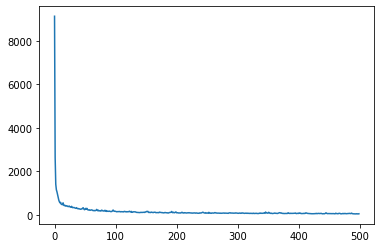

In [ ]:
plt.plot(all_losses)

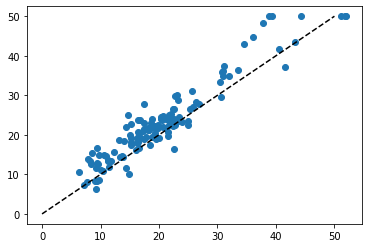

In [ ]:
y_pred = []
y_true = []
net.train(False)
for inputs, targets in test_loader:
    y_pred.extend(net(inputs).data.numpy())
    y_true.extend(targets.numpy())
plt.scatter(y_pred, y_true)
plt.plot([0, 50], [0, 50], '--k')

In [ ]:
for i in range(len(y_pred)):
  print(y_pred[i], y_true[i])

[18.193295] 21.8
[15.250212] 18.1
[25.828749] 27.0
[13.752766] 14.6
[9.597588] 12.6
[20.31755] 24.5
[16.399866] 18.3
[23.1089] 30.1
[24.976822] 22.6
[10.383213] 10.9
[20.636406] 24.8
[8.429264] 12.7
[51.126865] 50.0
[30.889393] 36.2
[22.475883] 26.6
[31.199945] 37.3
[18.719913] 23.9
[30.748005] 36.0
[9.302107] 6.3
[16.526516] 16.6
[26.812634] 27.9
[10.151379] 11.0
[26.293102] 28.2
[11.72546] 13.5
[16.241228] 19.3
[10.573637] 14.9
[17.239485] 21.0
[16.66843] 19.2
[9.379757] 13.0
[13.956825] 18.5
[43.279537] 43.5
[25.025066] 23.5
[18.373436] 21.2
[18.121632] 21.2
[19.41135] 19.0
[39.284267] 50.0
[16.819878] 23.7
[25.332527] 26.6
[33.481335] 36.4
[15.232334] 19.1
[19.38099] 22.2
[22.510723] 26.5
[14.352455] 11.7
[14.440231] 21.9
[13.242903] 18.6
[51.757458] 50.0
[14.750763] 25.0
[18.723263] 19.4
[18.916569] 22.0
[22.707596] 29.8
[21.5014] 20.7
[21.750546] 22.6
[7.8642383] 13.9
[17.853268] 19.4
[23.1963] 28.7
[34.5128] 43.1
[30.662867] 29.6
[21.945297] 23.0
[13.322504] 14.5
[22.608948] 16.

In [ ]:
print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))

MAE: 3.247902
MSE: 17.041819
R^2: 0.8279620206095593


MAE: 3.148492211275426
MSE: 20.011873172980735
R^2: 0.7979791908673539


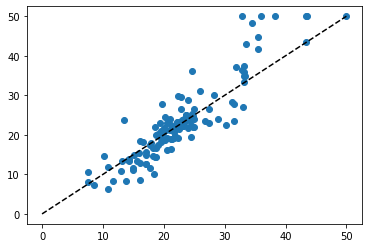

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import QuantileTransformer

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(
        n_quantiles=300, output_distribution='normal'))

regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)
plt.scatter(y_pred, y_test)
plt.plot([0, 50], [0, 50], '--k')
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))